In [14]:
# -*- coding: utf-8 -*- 
import numpy as np
import pandas as pd
import matplotlib as mpl 
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV,StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.metrics import r2_score, accuracy_score, mean_squared_error, auc, roc_curve
from sklearn.svm import SVC
from sklearn.feature_selection import VarianceThreshold,SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import lightgbm as lgbm
from matplotlib import colors
import joblib
mpl.rcParams.update(
    {
    'font.family': 'sans-serif',            #设置字体样式
    # 'font.size':16,
    'font.sans-serif': ['SimHei'],        
    # 'axes.labelsize': 16,
    # 'xtick.labelsize':16,
    # 'ytick.labelsize':16
    }
    )          
plt.rcParams['axes.unicode_minus'] = False   #用来正常显示负号

In [2]:
# # 数据读取
data= pd.read_excel(r'../数据/表2_update.xlsx')
data['类型'].loc[data['类型'] == '高钾']= 1
data['类型'].loc[data['类型'] == '铅钡']= 0
Y = data['类型'].astype('int64')
X = data.iloc[:, 5:]
x_train, x_test, y_train, y_test = train_test_split(X ,Y ,test_size= 0.2, random_state= 100)

c:\Users\syh\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [3]:
def draw_h2d(ax,Y_pre,Y, title):  # h-2d
    train_r2 = abs(r2_score(Y, Y_pre) )
    RMSE = (mean_squared_error(Y,Y_pre)**0.5)
    c = ax.hist2d(Y, Y_pre, bins=5, cmap='YlGnBu')
    ax.plot(Y,Y,c='#a61b29',label='y=x')
    ax.set_title(title+'R=%.3f RMSE=%.3f' % (train_r2**0.5,RMSE),loc='left',fontsize =15,fontweight='heavy')
    ax.set_ylim(0, np.max(Y))
    ax.set_xlim(0, np.max(Y))
    ax.set_xlabel('True Value ')
    ax.set_ylabel('Predicted Value')
    ##实际倾向率
    variance = np.var(Y, ddof=1)         # 计算方差，doff为贝塞尔（无偏估计）校正系数
    covariance = np.cov(Y, Y_pre)[0][1]  # 计算协方差
    w = covariance / variance
    b = np.mean(Y_pre) - w * np.mean(Y)
    y_line = w * Y+ b
    if b<0:
        ax.plot(Y, y_line, c='#15559a',label='y={}x{}'.format(round(w,4),round(b,4)))
    else:
        ax.plot(Y, y_line, c='#15559a',label='y={}x+{}'.format(round(w,4),round(b,4)))
    ax.legend(fontsize = 15)
    return c

def draw_h2d_plus(Classifier, y_pre, y_pre_train):
    mpl.rcParams.update(mpl.rcParamsDefault)  #还原默认绘图风格
    mpl.rc('font', size=15, weight='normal')  #设置全局字体大小 
    fig = plt.figure(figsize=(10,12))
    fig_ax1 = fig.add_axes([0.1, 0.6, 0.4, 0.3]) 
    fig_ax2 = fig.add_axes([0.6, 0.6, 0.4, 0.3])
    c = draw_h2d(fig_ax1, y_pre_train, y_train, Classifier + '_train:')  #随模型修改------
    c2= draw_h2d(fig_ax2, y_pre, y_test, Classifier + '_test:')
    cax = plt.axes([0.13,0.53 , 0.8, 0.02])
    cbar=plt.colorbar(c[3],cax=cax, orientation='horizontal')
    cbar.set_label("density")
    plt.show()

In [4]:
def calculate_auc(y_test, pred): #绘制roc曲线   
    fpr, tpr, thersholds = roc_curve(y_test, pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize= (6, 6))
    plt.plot(fpr, tpr, color= '#15559a', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.plot([0, 1], [0, 1], color= '#d1c2d3', linestyle= '--')
    plt.show()

c:\Users\syh\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:49:37] WARNING: D:\Build\xgboost\xgboost-1.5.1.git\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
训练集准确率： 1.0
测试集准确率： 1.0


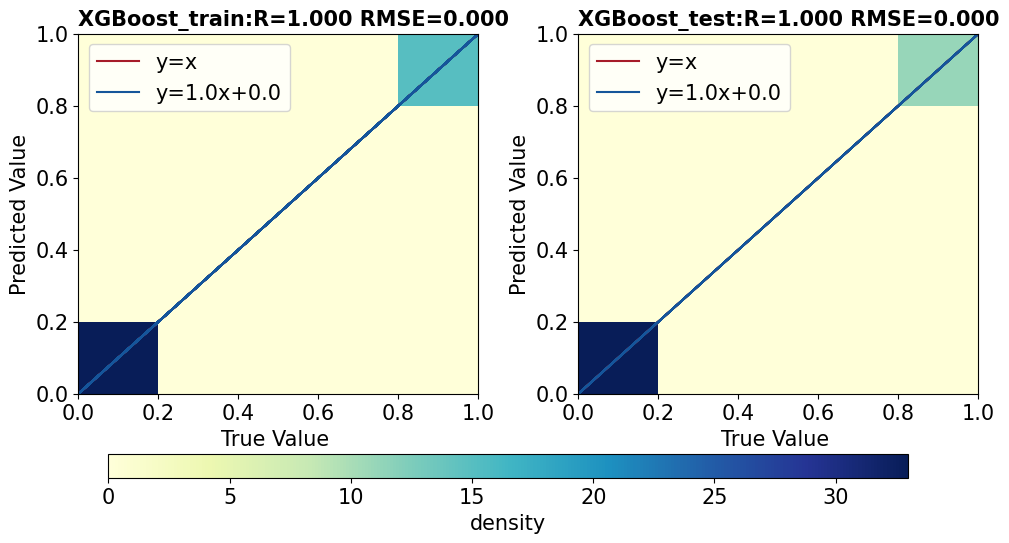

<Figure size 640x480 with 0 Axes>

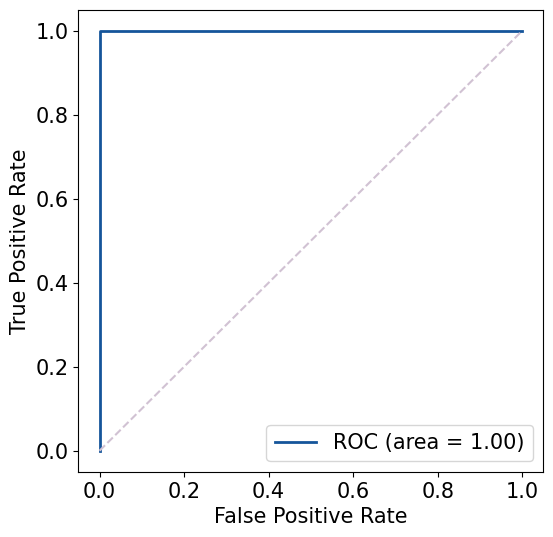

In [5]:
# 训练模型
clf = XGBClassifier()
clf.fit(x_train, y_train)
y_pre = clf.predict(x_test)
y_pre_train = clf.predict(x_train) 
print('训练集准确率：', accuracy_score(y_train, y_pre_train))
print('测试集准确率：', accuracy_score(y_test, y_pre))

# 储存模型
joblib.dump(filename= 'XGBoost.model', value= clf) #保存模型
# 绘图-h2d
draw_h2d_plus(Classifier= 'XGBoost', y_pre= y_pre, y_pre_train= y_pre_train)
calculate_auc(y_test= y_test, pred= y_pre)

准确率： 1.0


c:\Users\syh\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


<Figure size 640x480 with 0 Axes>

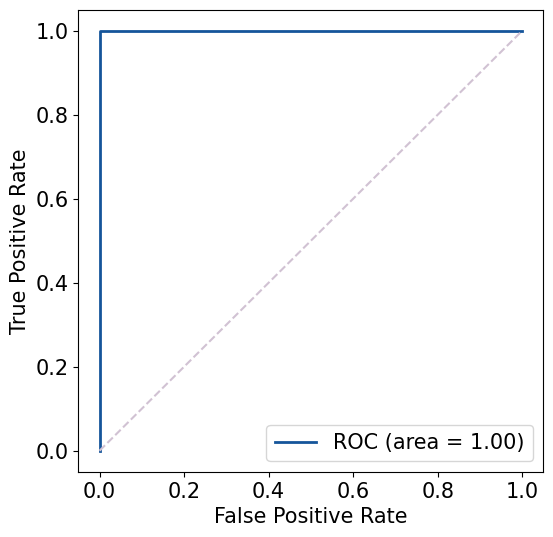

In [6]:
# sheet检验与验证
# 数据读取
data= pd.read_excel(r'../数据/Q3_表3_update.xlsx')
data['类型'].loc[data['类型'] == '高钾']= 1
data['类型'].loc[data['类型'] == '铅钡']= 0
y =  data['类型'].astype('int64')
x = data.iloc[:, 2:-1]
# 分类与检验
clf = joblib.load(filename= 'XGBoost.model')   #读取模型
y_pre = clf.predict(x)
print('准确率：', accuracy_score(y, y_pre))
# 绘图
calculate_auc(y_test= y, pred= y_pre)

#### 模型灵敏性检验

In [8]:
# 调参
cv_params = {
        # 'n_estimators':range(2,8,1),
        # 'learning_rate':np.linspace(0.01,2,6),
        'subsample':np.linspace(0.7,0.9,6),
        }
other_params = {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
                    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
model = XGBClassifier(**other_params)
gsearch2 = GridSearchCV(estimator=model, param_grid=cv_params, scoring='accuracy', cv=5, verbose=1, n_jobs=4)
gsearch2.fit(X,Y)
testscore3 = gsearch2.cv_results_['mean_test_score']
for i in testscore3:
    print('当前socre:',i)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


c:\Users\syh\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:51:57] WARNING: D:\Build\xgboost\xgboost-1.5.1.git\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
当前socre: 1.0
当前socre: 1.0
当前socre: 1.0
当前socre: 1.0
当前socre: 1.0
当前socre: 1.0


In [10]:
# 灵敏性绘图
import proplot as pplt
fig, ax = pplt.subplots(
                        refheight= 2, 
                        refwidth= 2,  #对单个图而言
                        ncols=3, 
                        share= False, 
                        )
ax[0].plot(np.arange(2,8), testscore1, lw= 2.6, marker='*',c='#008afb')
ax[1].plot(np.linspace(0.01, 2, 6), testscore2, lw= 2.6, marker='*',c='#008afb')
ax[2].plot(np.linspace(0.7, 0.9, 6), testscore3, lw= 2.6, marker='*',c='#008afb')
ax[0].format( xlim = (1.6, 7.4), ylim = (0, 1.1), xlabel= 'n_estimators')
ax[1].format( xlim = (-0.2, 2.2), ylim = (0, 1.1),xlabel= 'learning_rate')
ax[2].format( xlim = (0.68, 0.92), ylim = (0, 1.1),xlabel= 'subsample')
ax.format(xlabelsize= 14, ylabelsize= 14,yticks = 0.2, xticklabelsize= 14, yticklabelsize= 14,
          alpha= 0.8,abc= '(a)',abcsize= 14,linewidth = 1.2, grid= False)
plt.savefig(r'../图片/Q3_XGBoost_敏感性分析.png', dpi= 300)

#### 亚分类

In [11]:
# 规定变差系数Vp>0.8即可根据该变量划分亚类, 相对变率Vr>4.0即可视为一类
# 读取数据-无风化
data = pd.read_excel(r'../数据/Q3_表3_update.xlsx', index_col= '文物编号').drop(columns= ['表面风化','类型'])
# 变差系数与相对变率计算
Vp = data.std(skipna= True)/data.mean(skipna= True) #14个化学成分的变差系数
chem_vars = Vp[Vp>=0.8].index              #划分亚类的根据变量
Va = np.abs(data-data.mean(skipna= True))/(len(data)-data.isna().sum()) #14个化学成分的绝对变率
Vr = Va/data.mean(skipna= True) * 100               #各个数据的相对变率(%)
print('lenth of data:',len(data))

# 循环遍历分类的变量--查找显著不同的数据的位置
pos = pd.DataFrame()  #用于合并的空df
for i in chem_vars:
    Vr_temp = Vr[i]
    pos_temp = pd.DataFrame(data= {i:Vr_temp[Vr_temp>= 4 ].index.values})
    pos = pd.concat([pos, pos_temp], axis= 1)
    pos_i = pos.loc[:, i].dropna()
    data_pos = data.loc[pos_i, i]
    print('化学成分{}可分类数据:\n'.format(i), data_pos.sort_values())
    print('----------------------------分隔符---------------------------\n')
    # data_pos.sort_values().to_excel(r'../数据/Q3_亚分类_{}.xlsx'.format(i))

lenth of data: 14
化学成分氧化镁(MgO)可分类数据:
 文物编号
A8    0.000000
A7    0.161984
A6    0.181503
A1    1.860000
A2    1.997280
Name: 氧化镁(MgO), dtype: float64
----------------------------分隔符---------------------------

化学成分五氧化二磷(P2O5)可分类数据:
 文物编号
A7     0.13
A5     0.19
A6     0.21
A1     1.06
A8     1.46
A4     8.45
A2    14.27
Name: 五氧化二磷(P2O5), dtype: float64
----------------------------分隔符---------------------------



C:\Users\syh\AppData\Local\Temp/ipykernel_20932/2411278476.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Vp = data.std(skipna= True)/data.mean(skipna= True) #14个化学成分的变差系数
C:\Users\syh\AppData\Local\Temp/ipykernel_20932/2411278476.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Va = np.abs(data-data.mean(skipna= True))/(len(data)-data.isna().sum()) #14个化学成分的绝对变率
C:\Users\syh\AppData\Local\Temp/ipykernel_20932/2411278476.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Vr = 

In [15]:
# 亚分类绘图
import proplot as pplt
type_num_K = pd.DataFrame(data= {'K-Fe2O3':1,'others':2}, index= ['num'])
type_num_Pb = pd.DataFrame(data= {'Pb-Fe2O3':2,\
                        'Pb-P2O5':1,'others':2}, index= ['num'])
# 绘图
fig, ax = pplt.subplots(refheight= 2, refwidth= 2.5,ncols= 2,dpi= 300,)
ax[0].bar(type_num_K.T, c='#008afb')
ax[1].bar(type_num_Pb.T, c='#008afb')
ax[0].format( ylabel= 'Num',ylabelsize= 12,)
ax[0].format(title='高钾玻璃', titlesize= 12)
ax[1].format(title='铅钡玻璃', titlesize= 12)
ax.format(yticklabelsize= 10, xticklabelsize= 10,grid= False,
          ylocator= 1,abc= '(a)', abcsize= 12,abcweight= 'light')
plt.savefig('../图片/Q3_亚分类.png', dpi= 300)